In [1]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn joblib

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Cell 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
import warnings
warnings.filterwarnings("ignore")

# output dirs
OUT = "output"
FIGS = os.path.join(OUT, "figs")
MODELS = os.path.join(OUT, "models")
os.makedirs(FIGS, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)

sns.set(style="whitegrid")
print("Output folders:", OUT, FIGS, MODELS)


Output folders: output output\figs output\models


In [3]:
# Cell 3
df = pd.read_csv("diabetes.csv")   # put diabetes.csv in same folder as notebook
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


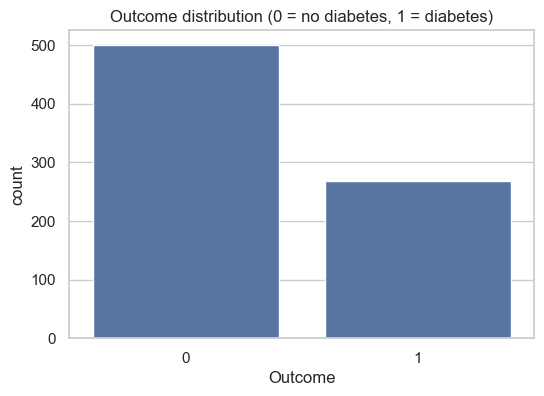

In [4]:
# Cell 4
print(df.info())
display(df.describe().T)

plt.figure(figsize=(6,4))
sns.countplot(x="Outcome", data=df)
plt.title("Outcome distribution (0 = no diabetes, 1 = diabetes)")
plt.savefig(os.path.join(FIGS, "target_distribution.png"), bbox_inches="tight")
plt.show()


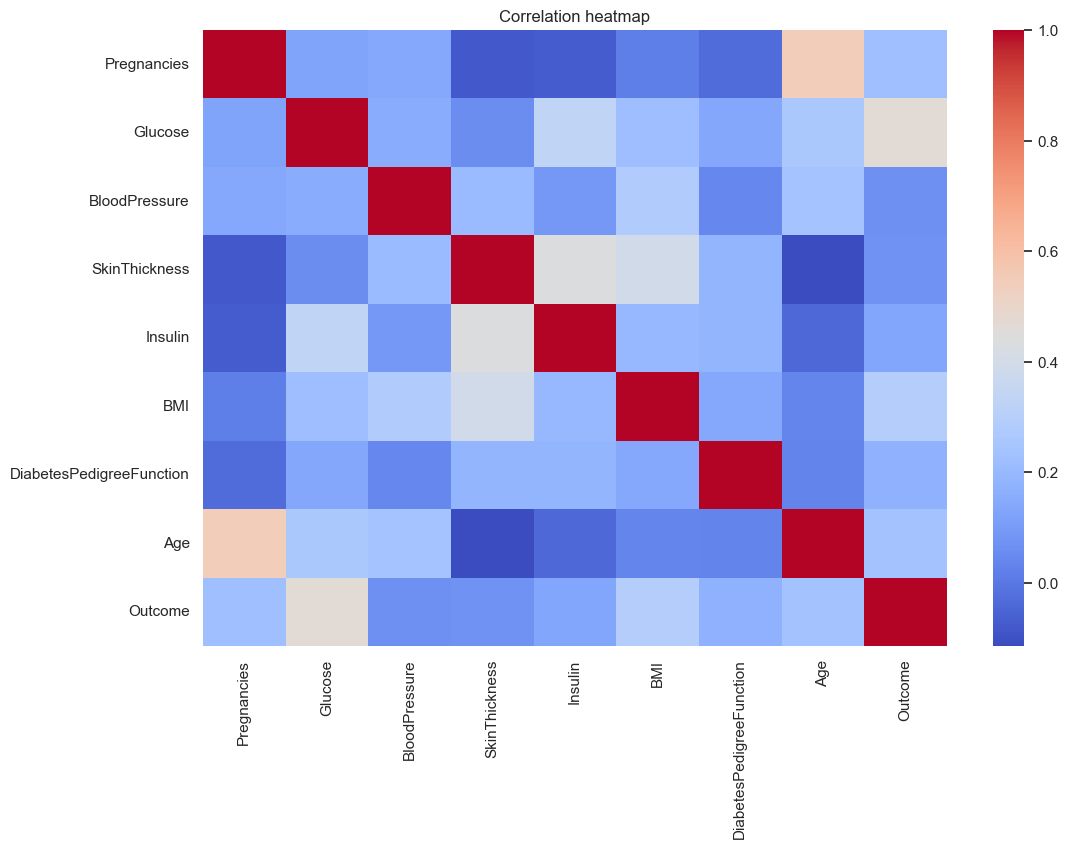

In [5]:
# Cell 5
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation heatmap")
plt.savefig(os.path.join(FIGS, "correlation_heatmap.png"), bbox_inches="tight")
plt.show()


In [6]:
# Cell 6
# In Pima dataset, some features use 0 as missing: Glucose, BloodPressure, SkinThickness, Insulin, BMI
cols_with_zero_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in cols_with_zero_missing:
    zero_count = (df[c] == 0).sum()
    print(f"{c} zeros: {zero_count}")

# Replace zeros with median (safe)
for c in cols_with_zero_missing:
    med = df.loc[df[c] != 0, c].median()  # median of non-zero values
    df[c] = df[c].replace(0, med)

print("\nAfter replacing zeros:")
display(df[cols_with_zero_missing].describe().T)


Glucose zeros: 5
BloodPressure zeros: 35
SkinThickness zeros: 227
Insulin zeros: 374
BMI zeros: 11

After replacing zeros:


,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,121.656250,30.438286,44.0,99.75,117.0,140.25,199.0
BloodPressure,768.0,72.386719,12.096642,24.0,64.00,72.0,80.00,122.0
SkinThickness,768.0,29.108073,8.791221,7.0,25.00,29.0,32.00,99.0
Insulin,768.0,140.671875,86.383060,14.0,121.50,125.0,127.25,846.0
BMI,768.0,32.455208,6.875177,18.2,27.50,32.3,36.60,67.1


In [7]:
# Cell 7
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())


X shape: (768, 8) y shape: (768,)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,125,33.6,0.627,50
1,1,85,66,29,125,26.6,0.351,31
2,8,183,64,29,125,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [8]:
# Cell 8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, os.path.join(MODELS, "scaler.joblib"))
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


In [9]:
# Cell 9
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

fitted = {}
for name, model in models.items():
    # RandomForest can use raw but scaled input is fine; we'll use scaled for consistency
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    fitted[name] = (model, acc)
    print(f"{name:18s} Accuracy: {acc:.4f}")


LogisticRegression Accuracy: 0.7078
RandomForest       Accuracy: 0.7403
SVM                Accuracy: 0.7403
KNN                Accuracy: 0.7273


In [10]:
# Cell 10
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, (model, _) in fitted.items():
    scores = cross_val_score(model, scaler.transform(X), y, cv=cv, scoring="accuracy")
    print(f"{name:18s} CV mean={scores.mean():.4f} std={scores.std():.4f}")


LogisticRegression CV mean=0.7734 std=0.0156
RandomForest       CV mean=0.7617 std=0.0193
SVM                CV mean=0.7552 std=0.0231
KNN                CV mean=0.7331 std=0.0083


Best model: RandomForest with test accuracy 0.7402597402597403
Accuracy: 0.7402597402597403

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



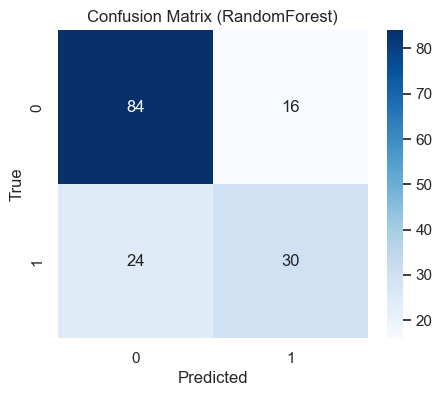

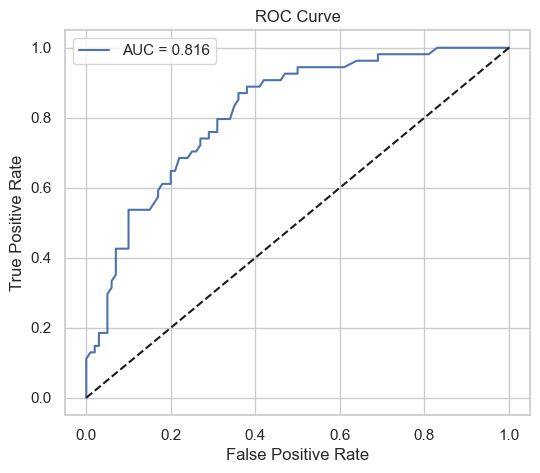

Saved model: output\models\best_diabetes_model_RandomForest.joblib


In [11]:
# Cell 11
# pick model with highest accuracy on test
best_name, best_acc = max(((n, acc) for n, (_, acc) in fitted.items()), key=lambda x: x[1])
best_model = fitted[best_name][0]
print("Best model:", best_name, "with test accuracy", best_acc)

# predictions & probabilities
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(FIGS, "confusion_matrix.png"), bbox_inches="tight")
plt.show()

# ROC if probabilities exist
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(os.path.join(FIGS, "roc_curve.png"), bbox_inches="tight")
    plt.show()

# Save model and metadata
model_fname = os.path.join(MODELS, f"best_diabetes_model_{best_name}.joblib")
joblib.dump({"name": best_name, "model": best_model, "scaler": scaler, "features": list(X.columns)}, model_fname)
print("Saved model:", model_fname)


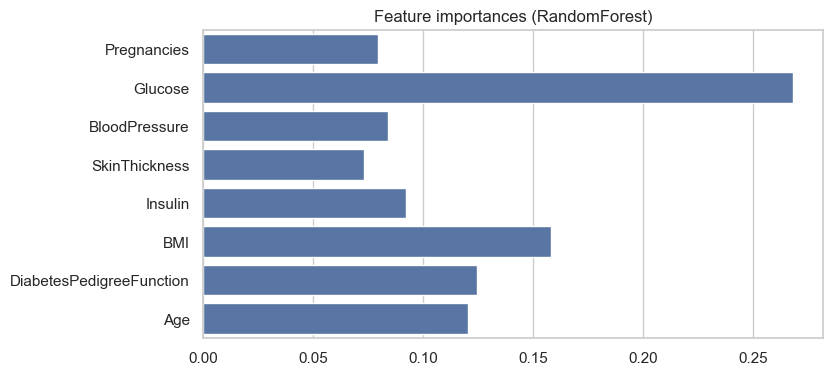

In [12]:
# Cell 12
features = X.columns.tolist()
plt.figure(figsize=(8,4))
if best_name in ("RandomForest",):
    importances = best_model.feature_importances_
    sns.barplot(x=importances, y=features)
    plt.title("Feature importances (RandomForest)")
    plt.savefig(os.path.join(FIGS, "feature_importances.png"), bbox_inches="tight")
    plt.show()
elif best_name == "LogisticRegression":
    coefs = best_model.coef_.ravel()
    sns.barplot(x=np.abs(coefs), y=features)
    plt.title("Mean |coef| per feature (Logistic Regression)")
    plt.savefig(os.path.join(FIGS, "feature_coefs.png"), bbox_inches="tight")
    plt.show()
else:
    print("Feature importance not available for", best_name)


In [13]:
# Cell 13
report = f"""
Diabetes Prediction Report
Best model: {best_name}
Test accuracy: {accuracy_score(y_test, y_pred):.4f}
Classification report:
{classification_report(y_test, y_pred)}
"""
open(os.path.join(OUT, "report.txt"), "w").write(report)
print("Report written to", os.path.join(OUT, "report.txt"))
print(report)


Report written to output\report.txt

Diabetes Prediction Report
Best model: RandomForest
Test accuracy: 0.7403
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154




numpy
pandas
matplotlib
seaborn
scikit-learn
joblib
